In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from numba import njit,prange
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from commonfunctions import *
from collections import defaultdict
from collections import Counter
from sklearn import svm
from sklearn import metrics
import seaborn as sns


import joblib



In [248]:
%%capture
%run  letters_extraction.ipynb


In [249]:
model_0_1 , model_letters, model_all = 0,0,0
d = 0

In [250]:
winSize = (16,16)
blockSize = (8,8)
blockStride = (8,8)
cellSize = (8,8)
nbins = 20

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

In [251]:
def prepare_image(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image = get_letters(image)[0]
    return image

def images_resize(directory):
    list_target_names = []
    list_images = []
        
    for path, subdirs, files in os.walk(directory):
        if(path.startswith(directory + '.')):
            continue
        files = [f for f in files if not f[0] == '.'] # Ignore '.directory' file
        print(path, len(files))
        # limit = 600
        # if len(files) > limit:
        #     files = files[:limit]
            
        for name in files:
            image=cv2.imread(os.path.join(path, name))
            image = prepare_image(image)
            # image=cv2.resize(image, (100, 100))
            list_target_names.append(os.path.basename(path))
            list_images.append(image)
    
    return list_target_names,  list_images 
 

In [252]:
def load_data(directory):
    global d;
    Name=[]
    for file in os.listdir(directory):
        Name+=[file]
    
    #################################
    d = defaultdict(int)
    co = 0
    for x in sorted(os.listdir(directory)):
        if not x.startswith('.') and not d[x]:
            d[x] = co
            co+=1
    #########################
    target_names,images = images_resize(directory)
    #########################
    # c = Counter(sorted(target_names))
    # target_names = [ d[key] for key in target_names ]
    target_names_shuffled, images_shuffled = shuffle(np.array(target_names), np.array(images))
    
    ############reshaping#############
    n_samples,nx,ny= images_shuffled.shape
    # n_samples,nx,ny= np.array(images).shape
    
    images_shuffled2 = np.array([hog.compute(image)  for image in images_shuffled])
    # images2 = np.array([hog.compute(image)  for image in images])
    images_shuffled2 = images_shuffled2.reshape(n_samples,-1)
    # images2 = images2.reshape(n_samples,-1)
        
    Xtrain, Xtest, ytrain, ytest = train_test_split(images_shuffled2, target_names_shuffled, random_state=0, test_size=0.2)
    # Xtrain, Xtest, ytrain, ytest = train_test_split(images2, target_names, train_size= 0.2, random_state=5, shuffle= True)
    
    return Xtrain, Xtest, ytrain, ytest 
    

In [253]:
def train_model( directory, filename, verbose = False):
    
    Xtrain, Xtest, ytrain, ytest = load_data(directory)

    ####### training #######
    model = svm.SVC(gamma = 0.001, C =100)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    
    ########### save model ########
    joblib.dump(model, filename)
    
    if(verbose):
        print(metrics.classification_report(ytest, ypred))
        print("Accuracy:",metrics.accuracy_score(ytest, ypred))
        # sns.set(rc={'figure.figsize':(15,12)})
        mat = confusion_matrix(ytest, ypred)
        print("DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD", d)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=list(d.keys()), yticklabels=list(d.keys()))
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        plt.show()
        
    return model

In [254]:
def initialize_models(verbose = False):
       global model_all;
       global model_0_1;
       global model_letters;
       model_all =train_model(directory= './all_symbols/', filename = './saved_models/model_all.sav', verbose= verbose)        
       model_0_1 =train_model(directory= './0_1_symbols/', filename = './saved_models/model_0_1.sav', verbose= verbose)
       model_letters =train_model(directory= './letters_only_symbols/', filename = './saved_models/model_letters.sav', verbose= verbose)
        

In [255]:
def load_models(is_expression = True, is_table = True):
    if(is_table):
        model_0_1 = joblib.load('./saved_models/model_0_1.sav')
        model_letters = joblib.load('./saved_models/model_letters.sav')
    
    if(is_expression):
        model_all = joblib.load('./saved_models/model_all.sav')
    

In [256]:
def classify(image, is_expression=False, is_0_1=False, is_letter=False):
    
    hog_images = np.array([hog.compute(image)  for image in image])
    if(is_letter):
        return model_letters.predict(hog_images)
    
    if(is_0_1):
        return model_0_1.predict(hog_images)
    
    # if(is_expression):
    return model_all.predict(hog_images)
    

./all_symbols/ 0
./all_symbols/( 55
./all_symbols/) 55
./all_symbols/+ 55
./all_symbols/A 55
./all_symbols/B 55
./all_symbols/C 55
./all_symbols/F 54
./all_symbols/implies 55
./all_symbols/xor 55
./all_symbols/~ 55
              precision    recall  f1-score   support

           (       1.00      1.00      1.00        16
           )       1.00      1.00      1.00         7
           +       1.00      1.00      1.00        12
           A       1.00      1.00      1.00        14
           B       1.00      1.00      1.00        11
           C       1.00      1.00      1.00        12
           F       1.00      1.00      1.00        11
     implies       1.00      1.00      1.00        10
         xor       1.00      1.00      1.00         7
           ~       1.00      1.00      1.00        10

    accuracy                           1.00       110
   macro avg       1.00      1.00      1.00       110
weighted avg       1.00      1.00      1.00       110

Accuracy: 1.0
DDDDDDDDDDDD

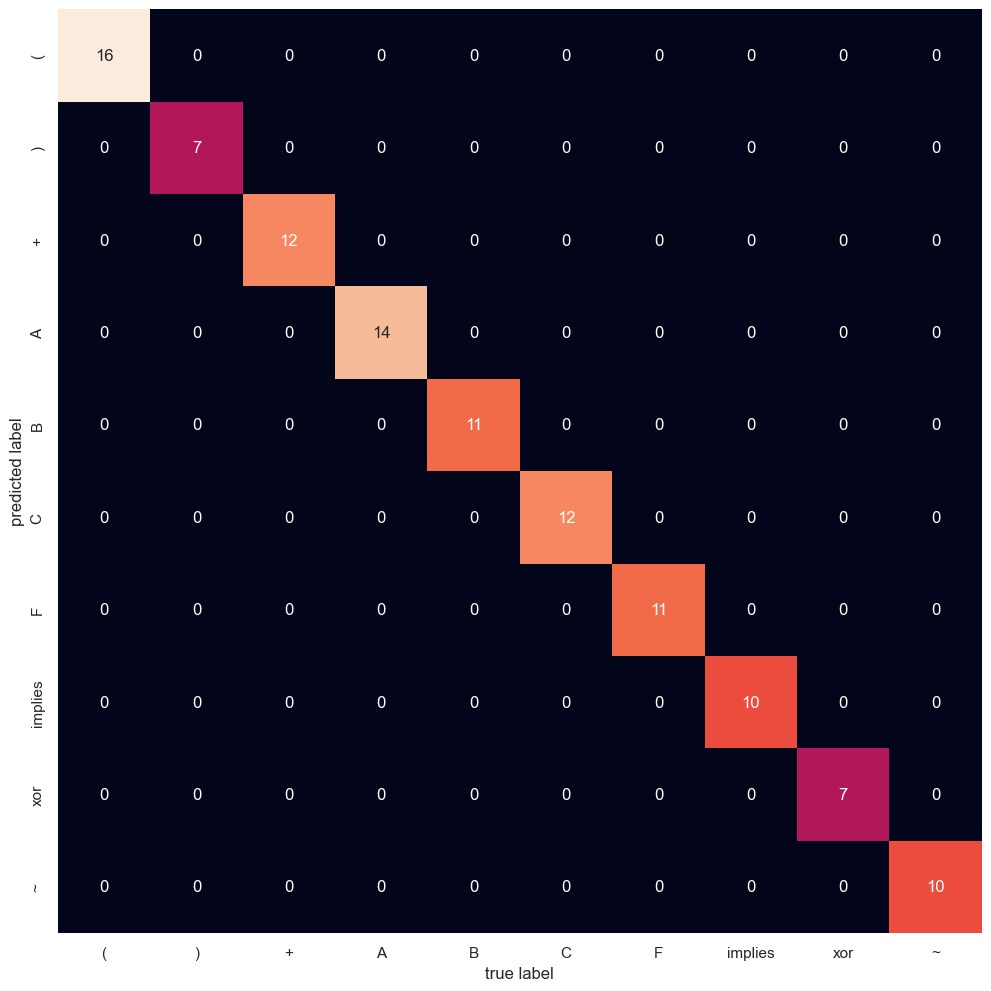

./0_1_symbols/ 0
./0_1_symbols/0 55
./0_1_symbols/1 55
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.92      1.00      0.96        11

    accuracy                           0.95        22
   macro avg       0.96      0.95      0.95        22
weighted avg       0.96      0.95      0.95        22

Accuracy: 0.9545454545454546
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD defaultdict(<class 'int'>, {'0': 0, '1': 1})


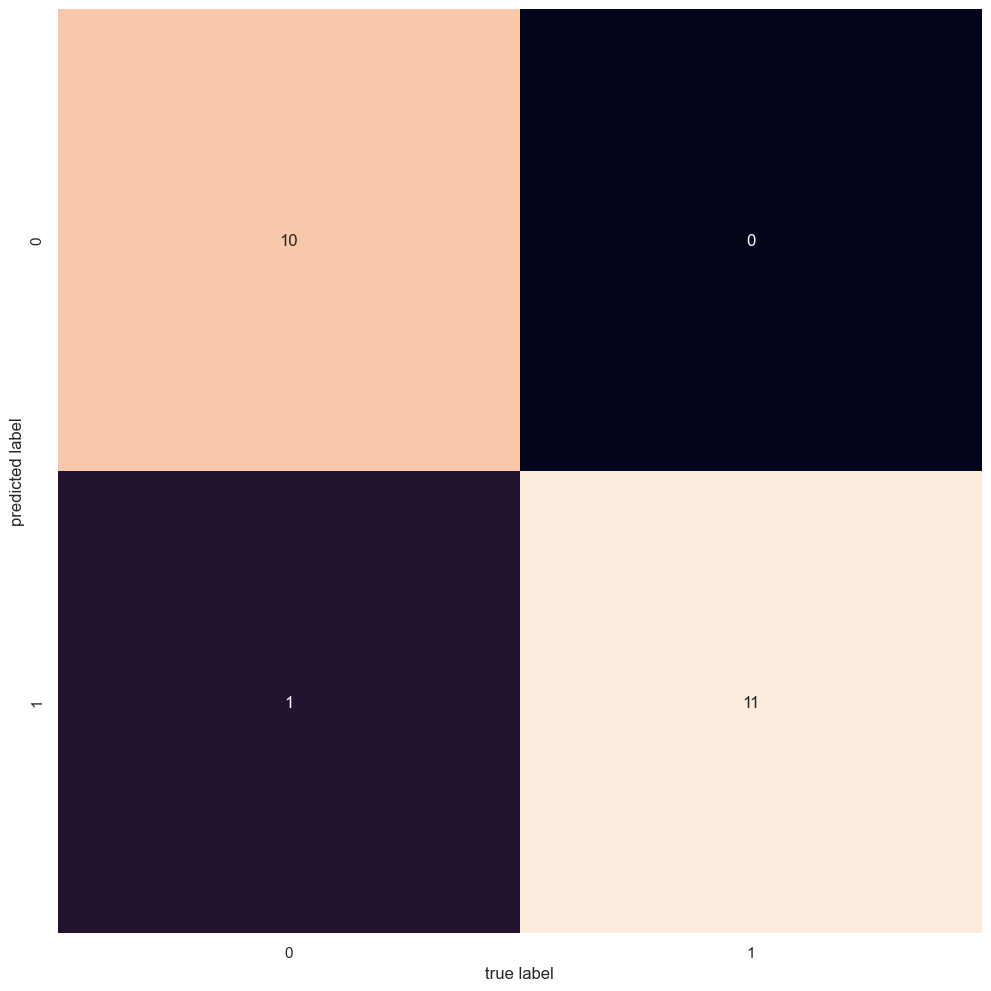

./letters_only_symbols/ 0
./letters_only_symbols/A 55
./letters_only_symbols/B 55
./letters_only_symbols/C 55
./letters_only_symbols/F 54
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       1.00      1.00      1.00        15
           C       1.00      1.00      1.00        10
           F       1.00      1.00      1.00        11

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44

Accuracy: 1.0
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD defaultdict(<class 'int'>, {'A': 0, 'B': 1, 'C': 2, 'F': 3})


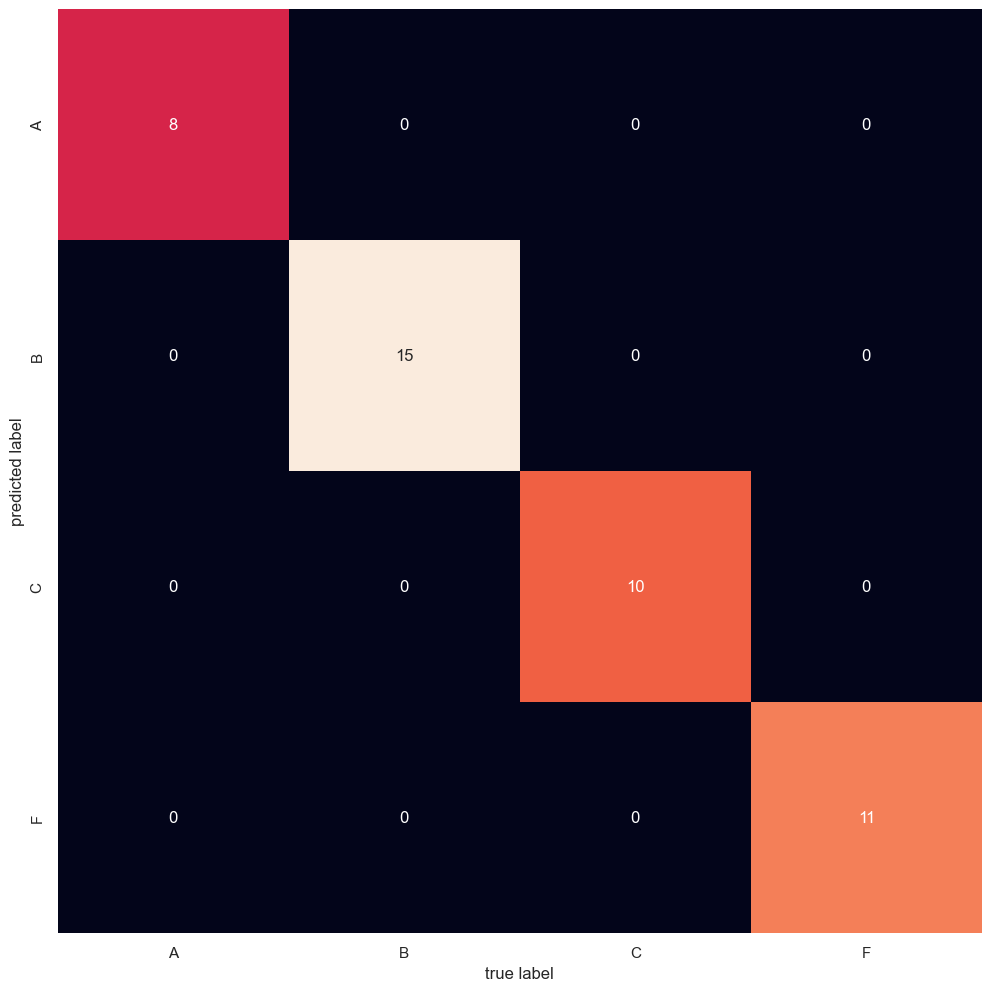

In [257]:
initialize_models(verbose= True)


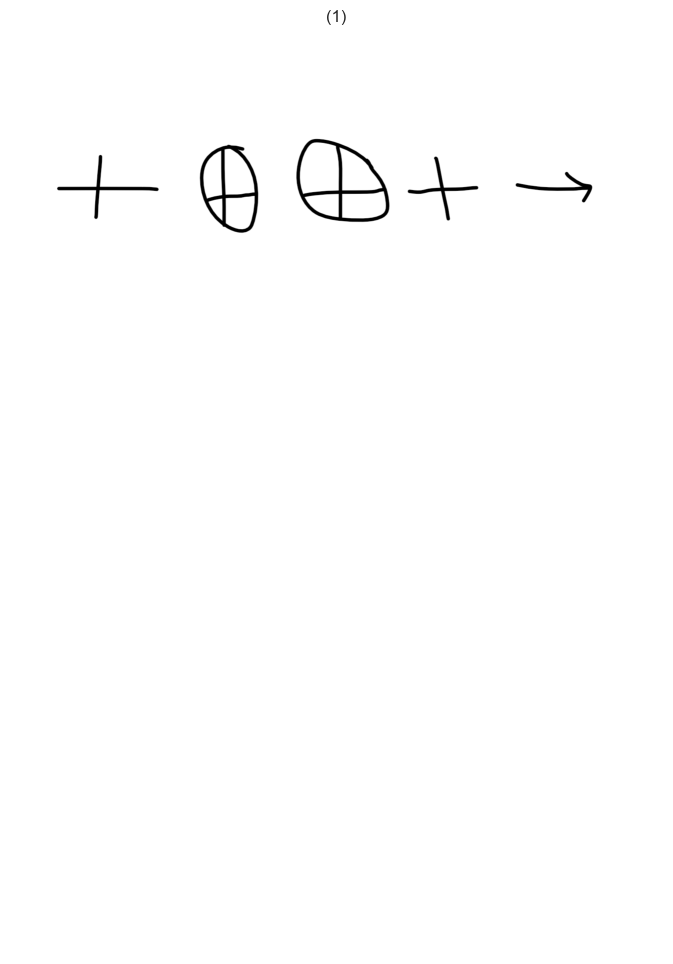

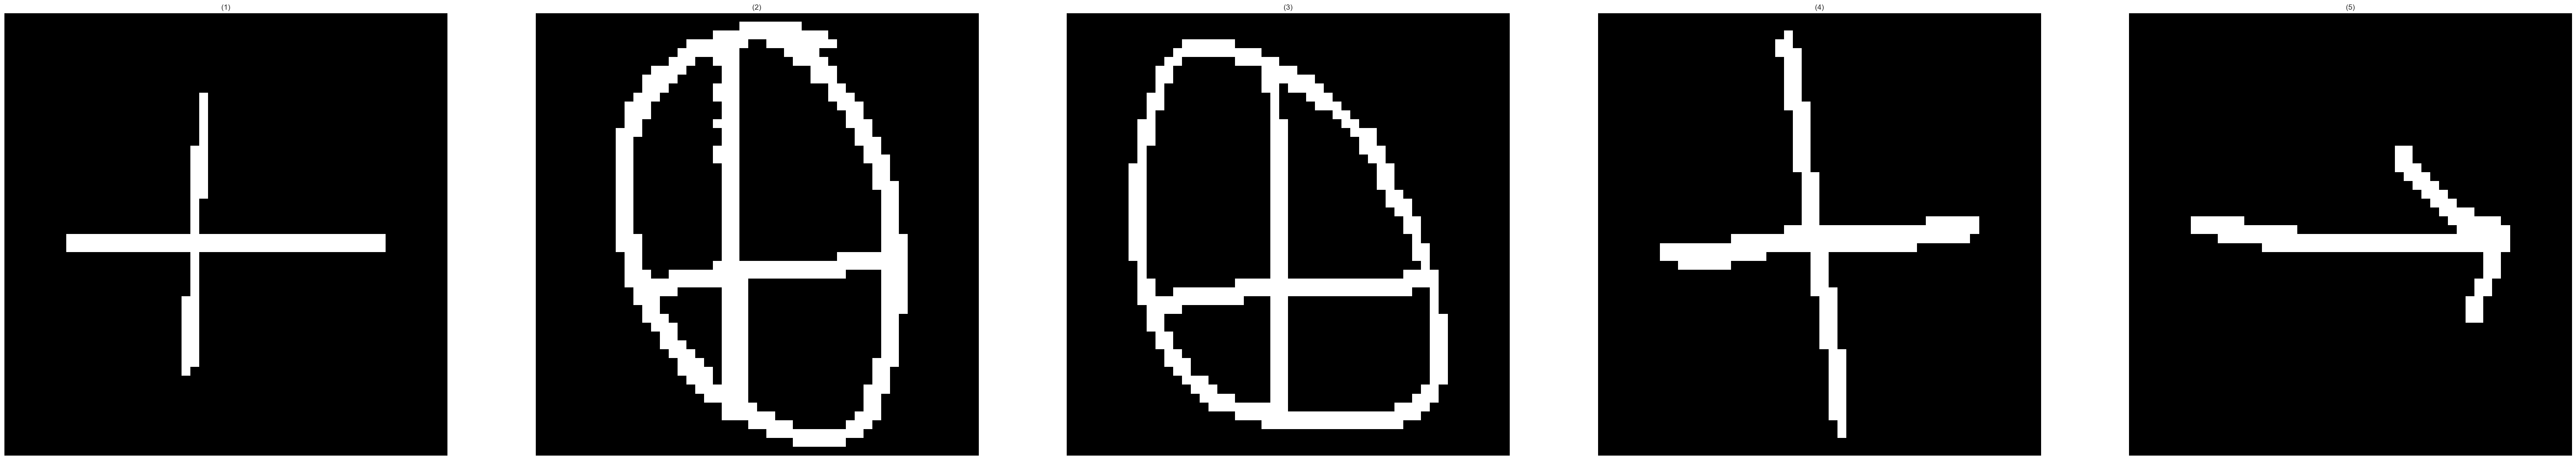

['+' 'xor' 'xor' '+' 'implies']


In [258]:
letters= cv2.cvtColor(cv2.imread(r"./test_images/classification1.png"), cv2.COLOR_BGR2GRAY)
show_images([letters])
letters_res = np.array(get_letters(letters, verbose= False))
show_images(letters_res)

# letters_res = np.array([hog.compute(image) for image in letters_res])
# print(letters_res.shape)

results = classify(letters_res, is_expression=True)

print(results)




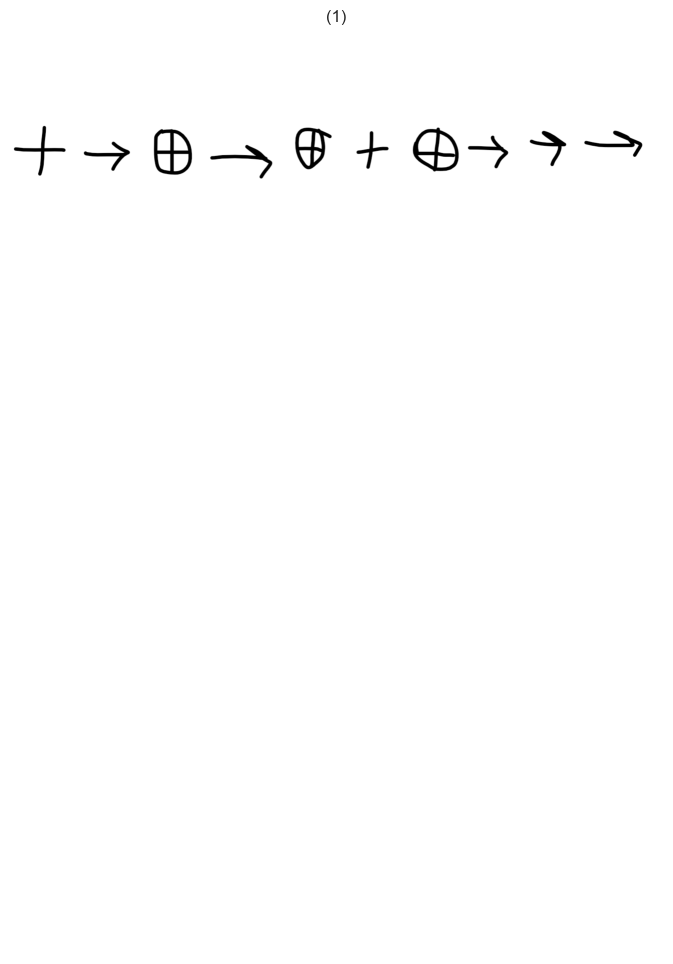

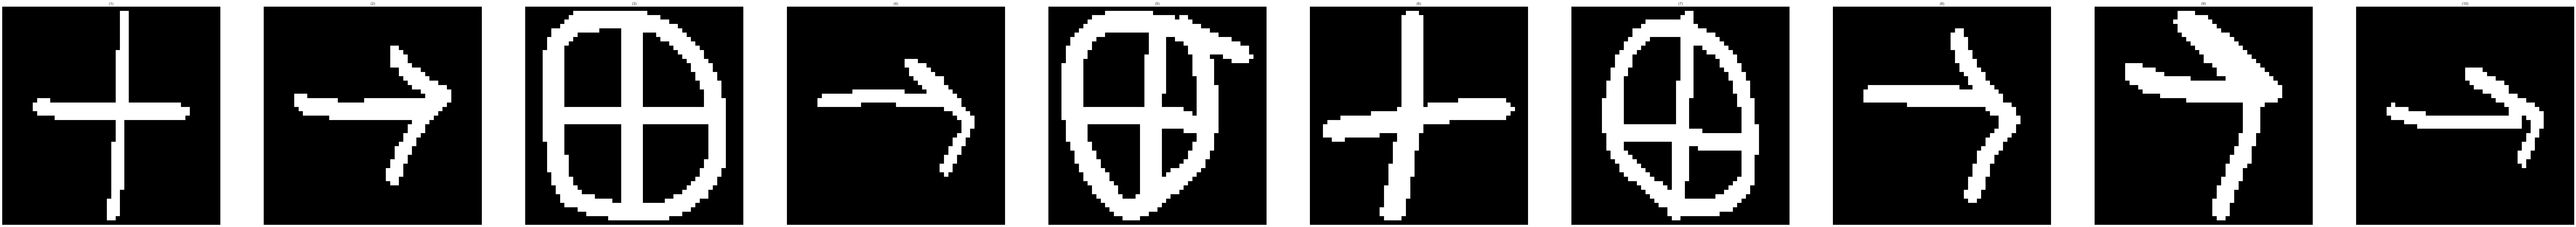

['+' 'implies' 'xor' 'implies' 'xor' '+' 'xor' 'implies' 'implies'
 'implies']


In [259]:
letters= cv2.cvtColor(cv2.imread(r"./test_images/classification2.png"), cv2.COLOR_BGR2GRAY)
show_images([letters])
letters_res = np.array(get_letters(letters, verbose= False))
show_images(letters_res)

results = classify(letters_res, is_expression=True)
print(results)